In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Grad-CAM imports (provided by the grad-cam package)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
## 2. Set Up Data Loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets (update the path to your dataset)
data_dir = 'D:\\OFFICE WORK\\KDD Summer 2025\\task3\\split_dataset'  # Replace with your dataset path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes  # ['no', 'yes']

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")


Dataset sizes: {'train': 202, 'val': 24, 'test': 27}
Class names: ['no', 'yes']


In [6]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18 and modify for binary classification
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Single output for binary classification
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
## 4. Train the Model

def train_model(model, criterion, optimizer, num_epochs=25):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs) > 0.5
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Best val Acc: {best_acc:.4f}')
    return model

# Train the model (run this cell only once to train and save the model)
model = train_model(model, criterion, optimizer, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5773 Acc: 0.7822
val Loss: 1.3398 Acc: 0.6250
Epoch 1/24
----------
train Loss: 0.4356 Acc: 0.8168
val Loss: 0.6783 Acc: 0.7083
Epoch 2/24
----------
train Loss: 0.3384 Acc: 0.8465
val Loss: 0.5080 Acc: 0.7917
Epoch 3/24
----------
train Loss: 0.1746 Acc: 0.9406
val Loss: 0.4481 Acc: 0.8750
Epoch 4/24
----------
train Loss: 0.1400 Acc: 0.9406
val Loss: 0.4417 Acc: 0.9167
Epoch 5/24
----------
train Loss: 0.1892 Acc: 0.9257
val Loss: 0.5408 Acc: 0.8333
Epoch 6/24
----------
train Loss: 0.1569 Acc: 0.9505
val Loss: 0.5986 Acc: 0.8750
Epoch 7/24
----------
train Loss: 0.0584 Acc: 0.9802
val Loss: 0.4279 Acc: 0.8750
Epoch 8/24
----------
train Loss: 0.0248 Acc: 1.0000
val Loss: 0.1729 Acc: 0.8750
Epoch 9/24
----------
train Loss: 0.0279 Acc: 0.9950
val Loss: 0.3615 Acc: 0.8750
Epoch 10/24
----------
train Loss: 0.0068 Acc: 1.0000
val Loss: 0.5342 Acc: 0.8750
Epoch 11/24
----------
train Loss: 0.0110 Acc: 1.0000
val Loss: 0.3508 Acc: 0.9167
Epoch 12/24
--

In [8]:
## 5. Evaluate the Model

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=['no', 'yes']))

# Load the best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
evaluate_model(model, dataloaders['test'])


Confusion Matrix:
[[11  0]
 [ 2 14]]
Classification Report:
              precision    recall  f1-score   support

          no       0.85      1.00      0.92        11
         yes       1.00      0.88      0.93        16

    accuracy                           0.93        27
   macro avg       0.92      0.94      0.93        27
weighted avg       0.94      0.93      0.93        27



In [9]:
## 6. Set Up Grad-CAM and Visualization

# Wrapper for binary classification to work with Grad-CAM
class BinaryModelWrapper(nn.Module):
    def __init__(self, model):
        super(BinaryModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, x):
        output = self.model(x)
        return torch.cat([1 - torch.sigmoid(output), torch.sigmoid(output)], dim=1)

# Define inference transform
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prediction and visualization function
def predict_and_visualize(image_path, model, cam, threshold=0.5):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = inference_transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        prediction = 'yes' if prob > threshold else 'no'
    
    # Generate Grad-CAM if positive
    if prediction == 'yes':
        wrapped_model = BinaryModelWrapper(model)
        targets = [ClassifierOutputTarget(1)]  # Target class 1 (yes)
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        # Overlay heatmap on image
        image_np = np.array(image.resize((224, 224))) / 255.0
        visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    else:
        visualization = None
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Prediction: {prediction} (Prob: {prob:.4f})')
    plt.axis('off')
    
    if visualization is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title('Grad-CAM Tumor Region')
        plt.axis('off')
    
    plt.show()


C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


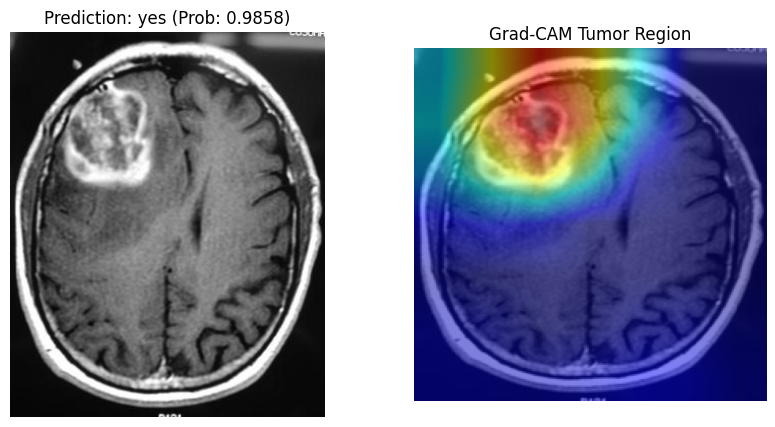

In [12]:
## 7. Load Model and Perform Analysis Without Retraining

# Load the saved model (run this cell to start analyzing without retraining)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()

# Set up Grad-CAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=BinaryModelWrapper(model), target_layers=target_layers)

# Example usage: replace with your image path
test_image_path = 'D:\\OFFICE WORK\\KDD Summer 2025\\task3\\test.jpg'  # Update with an actual image path
predict_and_visualize(test_image_path, model, cam)

Visualizing: D:\OFFICE WORK\KDD Summer 2025\task3\split_dataset\test\no\12 no.jpg


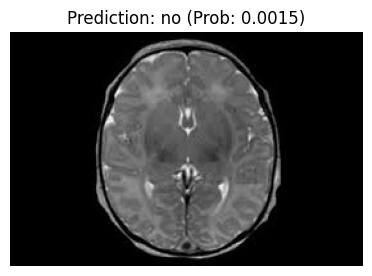

Visualizing: D:\OFFICE WORK\KDD Summer 2025\task3\split_dataset\test\no\22 no.jpg


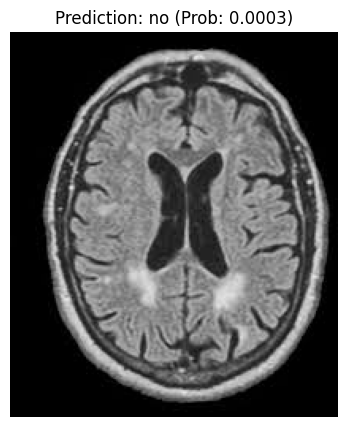

Visualizing: D:\OFFICE WORK\KDD Summer 2025\task3\split_dataset\test\no\23 no.jpg


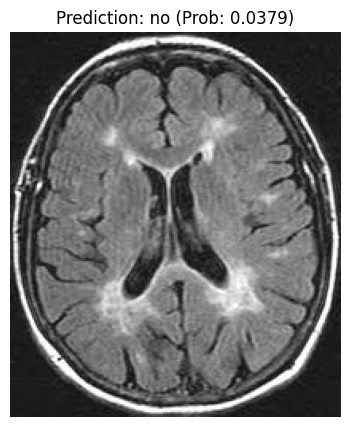

Visualizing: D:\OFFICE WORK\KDD Summer 2025\task3\split_dataset\test\no\26 no.jpg


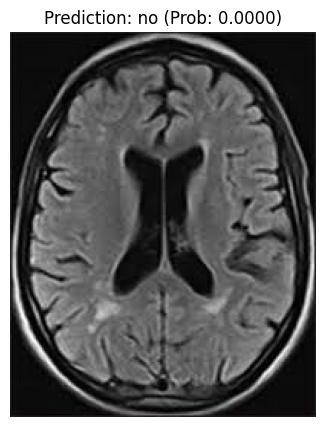

Visualizing: D:\OFFICE WORK\KDD Summer 2025\task3\split_dataset\test\no\36 no.jpg


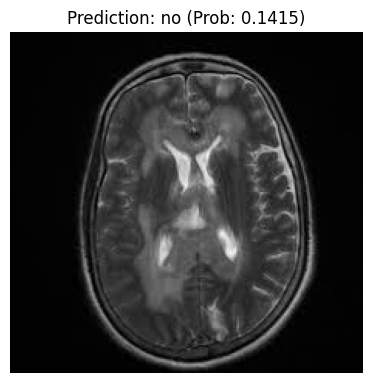

In [13]:
## 8. Visualize Multiple Test Images

# Visualize 5 test images as examples
test_dataset = image_datasets['test']
for i in range(min(5, len(test_dataset))):
    image_path = test_dataset.imgs[i][0]
    print(f"Visualizing: {image_path}")
    predict_and_visualize(image_path, model, cam)


# Notes

- **Dataset Path**: Update `data_dir` with the path to your dataset.
- **File Formats**: The code handles both `.jpg` and `.JPG` extensions via `ImageFolder`.
- **Segmentation**: Grad-CAM provides an approximate tumor region for positive predictions, not a precise segmentation mask.
- **Usage**: After training once, use sections 7 and 8 to analyze images without retraining by loading the saved model.